In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

from utils import tf_config

dataset="01"
memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=2)#02 [2, 3, 5, 7, 11]
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

import GPyOpt

import argparse

from utils import preprocess_data, search_algorithms, train, losses_utils, metrics, eeg_utils, data_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

from pathlib import Path

import time

import pickle

n_individuals=getattr(data_utils, "n_individuals_"+dataset)

with tf.device('/CPU:0'):
    train_data, test_data = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train =train_data
    eeg_test, fmri_test = test_data
    
    _, test_raw_data = preprocess_data.dataset(dataset, n_individuals=n_individuals,interval_eeg=interval_eeg, raw_eeg=True,ind_volume_fit=False,iqr=False,verbose=False)
    eeg_test_raw,_=test_raw_data

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [4]:
theta=eeg_to_fmri.parameters
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True

In [5]:
with open(str(Path.home())+"/eeg_to_fmri/na_models_eeg/na_specification_2", "rb") as f:
    na_specification_eeg = pickle.load(f)
with open(str(Path.home())+"/eeg_to_fmri/na_models_fmri/na_specification_2", "rb") as f:
    na_specification_fmri = pickle.load(f)

In [6]:
with tf.device('/CPU:0'):

    model = eeg_to_fmri.EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification_eeg, n_channels,
                    weight_decay=weight_decay, skip_connections=True, batch_norm=True, fourier_features=True,
                    random_fourier=True, conditional_attention_style=True,
                    conditional_attention_style_prior=True, local=True, seed=None, 
                    fmri_args = (latent_dimension, fmri_train.shape[1:], kernel_size, stride_size, n_channels, 
                    max_pool, batch_norm, weight_decay, skip_connections,
                    n_stacks, True, False, outfilter, dropout, None, False, na_specification_fmri))
    
    model.build(eeg_train.shape, fmri_train.shape)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses_utils.mae_cosine

    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    dev_set= tf.data.Dataset.from_tensor_slices((eeg_test, fmri_test)).batch(1)

In [7]:
train.train(train_set, model, optimizer, loss_fn, epochs=1, u_architecture=True, val_set=None, verbose=True, verbose_batch=True)

2023-01-31 14:53:06.710240: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-31 14:53:06.710564: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1 with loss: 0.9777357065303816


# Making the demonstration video

<IPython.core.display.Javascript object>


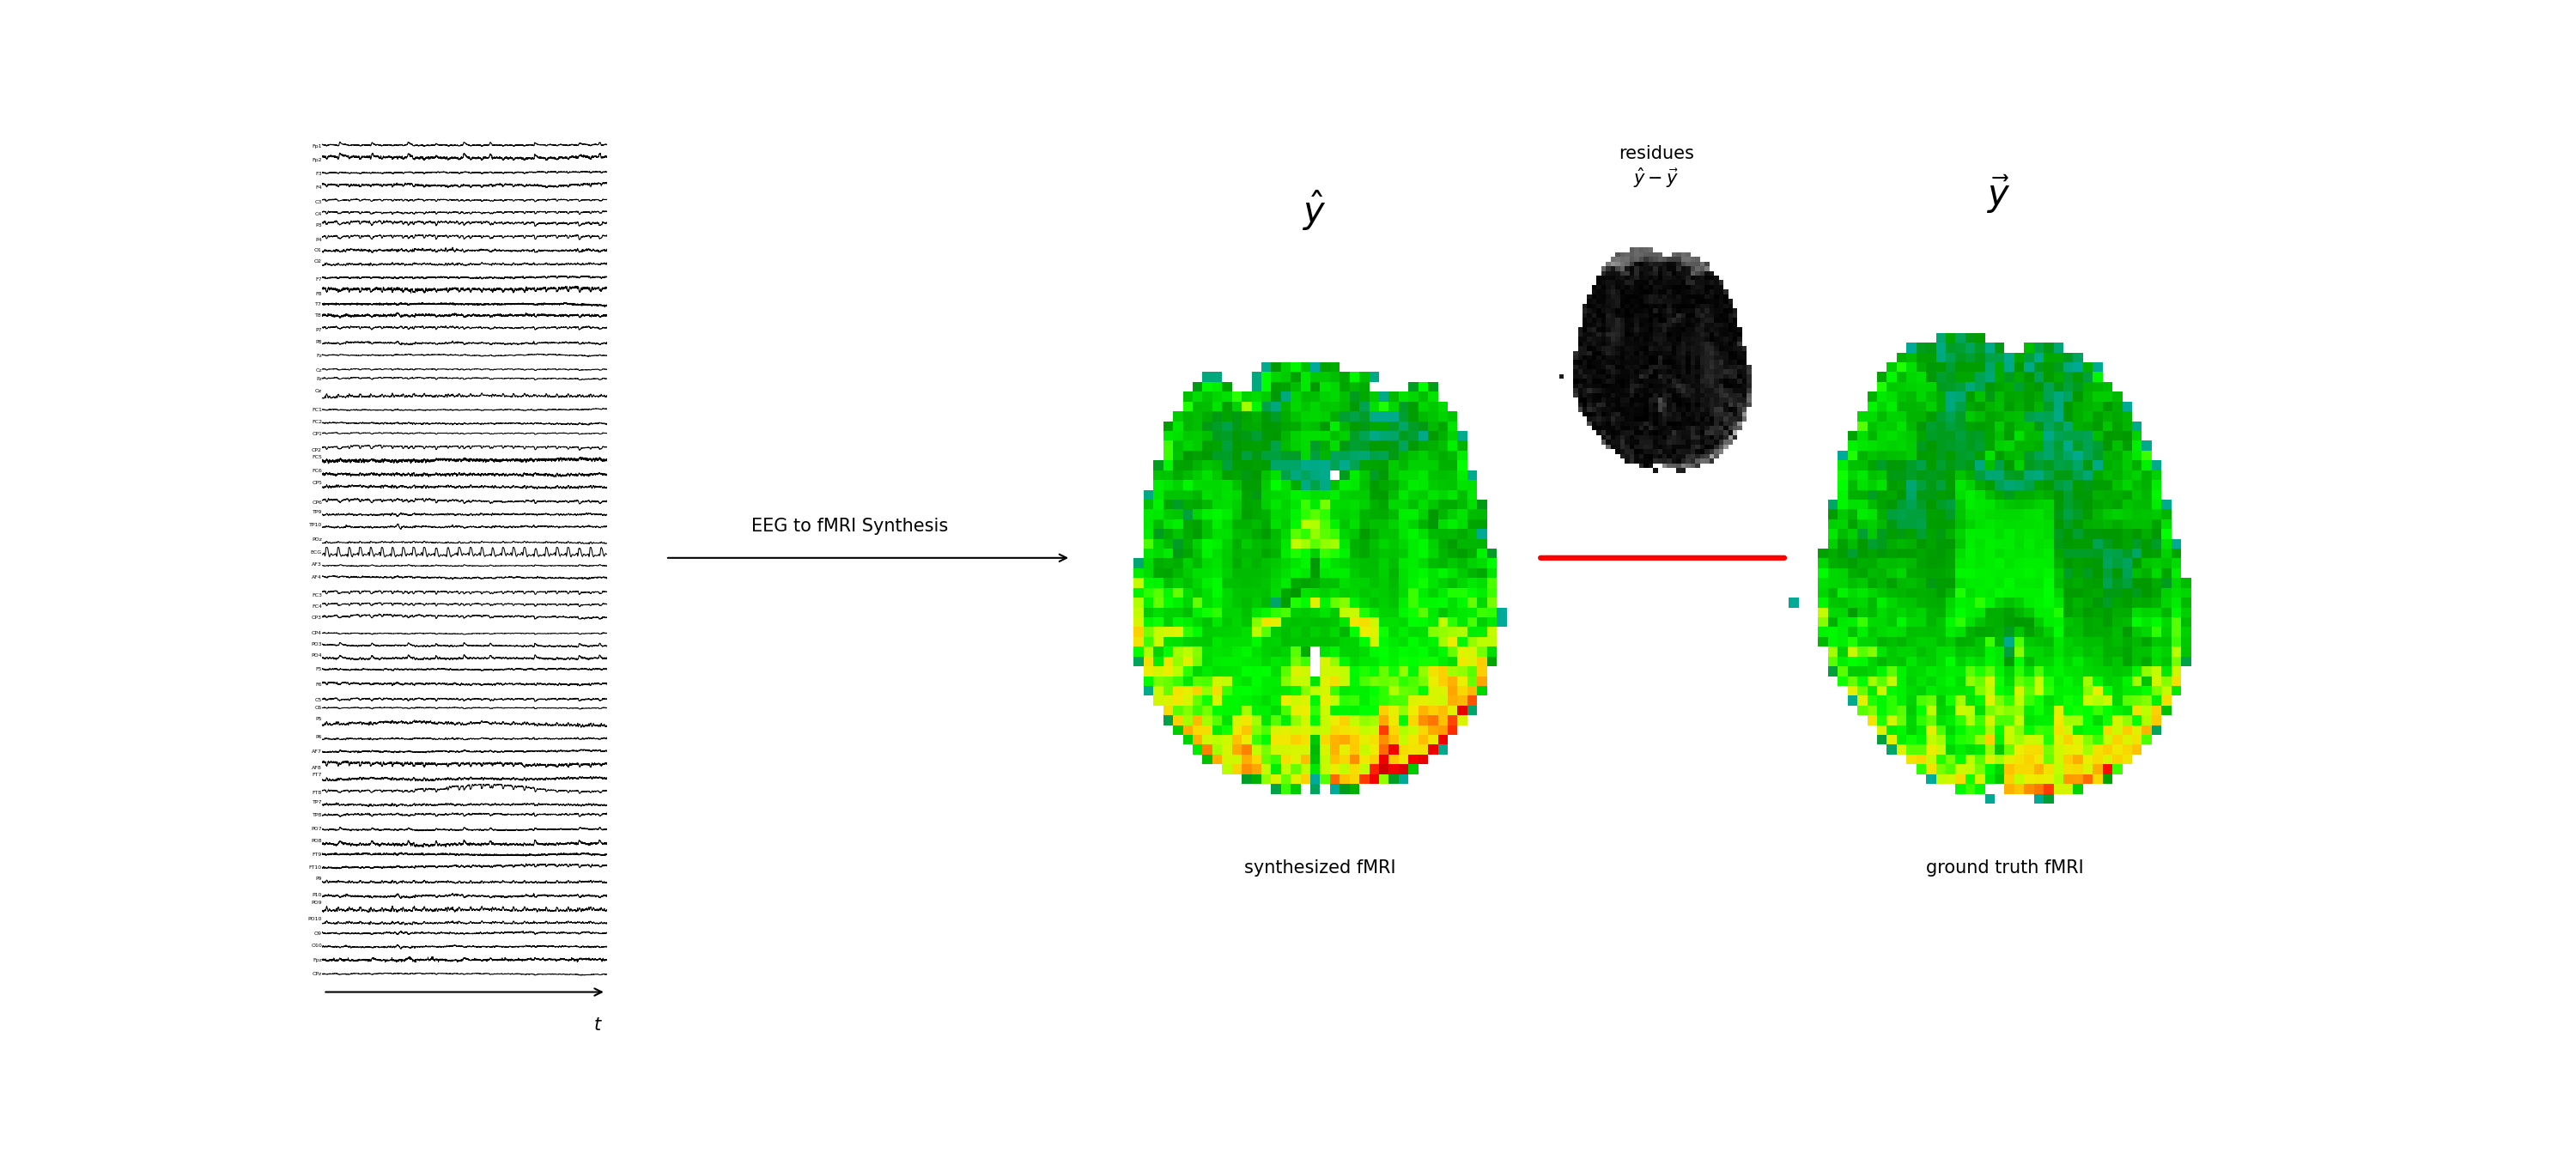

In [85]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from functools import partial
import matplotlib as mpl

from scipy.ndimage import rotate
import copy

fig = plt.figure(figsize=(20,9))
gs=mpl.gridspec.GridSpec(68, 6)    
x_axes=[]
y_axes=[]
eeg_channel_lines=[]
true_fmri_im=None
predicted_fmri_im=None
eps=1e-3
xlimit=1
threshold=0.37

cmap_im=copy.copy(mpl.cm.get_cmap(plt.cm.nipy_spectral))
cmap_im.set_over("white")
cmap_err=copy.copy(mpl.cm.get_cmap(plt.cm.gist_gray))
cmap_err.set_over("white")

for axis_plot in range(eeg_train.shape[1]):
    axes=fig.add_subplot(gs[axis_plot:axis_plot+1,0],)
    eeg_channel_lines+=[axes.plot([], [], color='black', linestyle='-', linewidth=0.5)[0]]
    #axis.set_xticks()
    axes.set_axis_off()
    #axis.set_xlim()
    axes.set_ylim(np.amin(eeg_test_raw[:,axis_plot,:,0])-eps, np.amax(eeg_test_raw[:,axis_plot,:,0])+eps)
    axes.set_xlim(0, xlimit)
    axes.text(-0., 0., getattr(eeg_utils, "channels_"+dataset)[axis_plot], fontdict={'size'   : 3}, horizontalalignment="right", verticalalignment="center")
    #add the data for the lines
    x_axes+=[np.array([])]
    y_axes+=[np.array([])]

#temporal arrow
axes=fig.add_subplot(gs[64:65,0],)
axes.set_axis_off()
axes.annotate("", xy=(1., 0.), xytext=(0, 0),arrowprops=dict(arrowstyle="->"))
#annotate with t
axes.text(0.95, -3.5, r'$t$',)
#axis for predicted fmri
axes=fig.add_subplot(gs[0:64,2:4],)
axes.set_axis_off()
im_synth=axes.imshow(cmap(np.full_like(np.zeros((64,64)), 1.0001)))
#axes for true fmri
axes=fig.add_subplot(gs[0:64,4:6],)
axes.set_axis_off()
im_fmri=axes.imshow(cmap(np.full_like(np.zeros((64,64)), 1.0001)))

#legend for predicted fmri
axes=fig.add_subplot(gs[55,2:4],)
axes.set_axis_off()
axes.text(0.5, 0.5, 'synthesized fMRI',horizontalalignment="center", verticalalignment="center")
#legend for true fmri
axes=fig.add_subplot(gs[55,4:6],)
axes.set_axis_off()
axes.text(0.5, 0.5, 'ground truth fMRI',horizontalalignment="center", verticalalignment="center")
#arrow connecting to predicted and true fmri
axes=fig.add_subplot(gs[31:32,3:5],)
axes.set_axis_off()
axes.annotate("", xy=(0.7, 0.), xytext=(0.3, 0),arrowprops=dict(arrowstyle="-",edgecolor='red', lw=3))
#residues mini plot
axes=fig.add_subplot(gs[5:28,3:5],)
axes.set_axis_off()
im_res=axes.imshow(cmap(np.full_like(np.zeros((64,64)), 1.0001)))
#annotate residues
axes=fig.add_subplot(gs[3,3:5],)
axes.set_axis_off()
axes.text(0.49, 2, 'residues\n'+r'$\hat{y}-\vec{y}$',horizontalalignment="center", verticalalignment="center")
#annotate math prediction
axes=fig.add_subplot(gs[5,2:4],)
axes.set_axis_off()
axes.text(0.49, 0.5, r'$\hat{y}$',horizontalalignment="center", verticalalignment="center",fontdict={'size'   : 20},)
#annotate math ground truth
axes=fig.add_subplot(gs[5,4:6],)
axes.set_axis_off()
axes.text(0.49, 2,r'$\vec{y}$',horizontalalignment="center", verticalalignment="center",fontdict={'size'   : 20},)
#arrow that connects EEG to prediction
axes=fig.add_subplot(gs[31:32,1:3],)
axes.set_axis_off()
axes.annotate("", xy=(0.65, 0.), xytext=(0., 0),arrowprops=dict(arrowstyle="->"))
axes=fig.add_subplot(gs[29:30,1],)
axes.set_axis_off()
axes.text(0.65, 0.5, 'EEG to fMRI Synthesis',horizontalalignment="center", verticalalignment="center")

def init_lines():
    eeg_channel_lines.set_data([],[])
    return eeg_channels_lines+(im_fmri,im_synth,im_res)

def update_eeg(frame, lines, im_true, im_pred, im_err, eeg_data, fmri_data, x, y,frame_duration=1.):
    for channel in range(len(lines)):
        x[channel]=np.linspace(xlimit-(frame_duration), xlimit, int(eeg_data.shape[2]*(frame_duration)),)
        y[channel]=eeg_data[int(frame),channel,:,0]
        lines[channel].set_data(x[channel],y[channel])
    
    #fmri normalization
    instance=fmri_data[int(frame)]
    predicted=model.decoder(eeg_train[int(frame):int(frame)+1]).numpy()[0]
    predicted=(predicted[:,:,:,:]-np.amin(instance[:,:,:,:]))/(np.amax(instance[:,:,:,:])-np.amin(instance[:,:,:,:]))
    instance=(instance[:,:,:,:]-np.amin(instance[:,:,:,:]))/(np.amax(instance[:,:,:,:])-np.amin(instance[:,:,:,:]))
    residues=np.abs(predicted-instance)
    residues[np.where(instance < threshold)]=1.001
    predicted[np.where(predicted < threshold)]=1.001
    instance[np.where(instance < threshold)]=1.001
    #set array with new volume
    im_true.set_array(cmap_im(rotate(instance[:,:,15,0], 90)))
    im_pred.set_array(cmap_im(rotate(predicted[:,:,15,0], 90)))
    im_err.set_array(cmap_err(rotate(residues[:,:,15,0], 90)))
    
    return tuple(lines)+(im_true,im_pred,im_err)
    

ani = FuncAnimation(fig, update_eeg, fargs=(eeg_channel_lines, im_fmri, im_synth, im_res, eeg_test_raw, fmri_test, x_axes, y_axes),
    frames=np.linspace(1, fmri_test.shape[0]//2, fmri_test.shape[0]//2), blit=True, save_count=1500)

f=str(Path.home())+"/eeg_to_fmri/src/notebooks/video_eeg_fmri.mp4"
mpl.rcParams['animation.ffmpeg_path']=str(Path.home())+r"/anaconda3/envs/eeg_fmri/bin/ffmpeg"
writervideo=FFMpegWriter(fps=2)
ani.save(f, writer=writervideo)

#f=str(Path.home())+"/eeg_to_fmri/src/notebooks/video_eeg_fmri.gif" 
#writergif=PillowWriter(fps=30) 
#ani.save(f, writer=writergif)

In [21]:
predicted=model.decoder(eeg_train[int(1):int(1)+1]).numpy()[0]

In [20]:
predicted

array([[[[-0.61640537],
         [-0.62703854],
         [-0.6119589 ],
         ...,
         [-0.6200543 ],
         [-0.614511  ],
         [-0.6212407 ]],

        [[-0.61695427],
         [-0.6233479 ],
         [-0.615934  ],
         ...,
         [-0.6181469 ],
         [-0.61777246],
         [-0.61226   ]],

        [[-0.6171423 ],
         [-0.6164628 ],
         [-0.6082093 ],
         ...,
         [-0.6147607 ],
         [-0.6200642 ],
         [-0.60813683]],

        ...,

        [[-0.62296456],
         [-0.62132174],
         [-0.6158042 ],
         ...,
         [-0.6159868 ],
         [-0.61973894],
         [-0.6136465 ]],

        [[-0.6111807 ],
         [-0.6168771 ],
         [-0.6127038 ],
         ...,
         [-0.62134975],
         [-0.6098839 ],
         [-0.6155469 ]],

        [[-0.6232727 ],
         [-0.615959  ],
         [-0.6130258 ],
         ...,
         [-0.61775386],
         [-0.60245544],
         [-0.62072104]]],


       [[[-0.5787107 ],
